Asignatura: Visión por Computador
Alumnos: Yeray Álvarez-Buylla Parra, María Elena Navarro Santana
Práctica 2

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time 

TAREA: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.95*maxfil.

Valor máximo de píxeles blancos por fila (maxfil): 0.4296875
Filas con al menos el 95% de maxfil (umbral = 0.408203125):
[ 12 100]


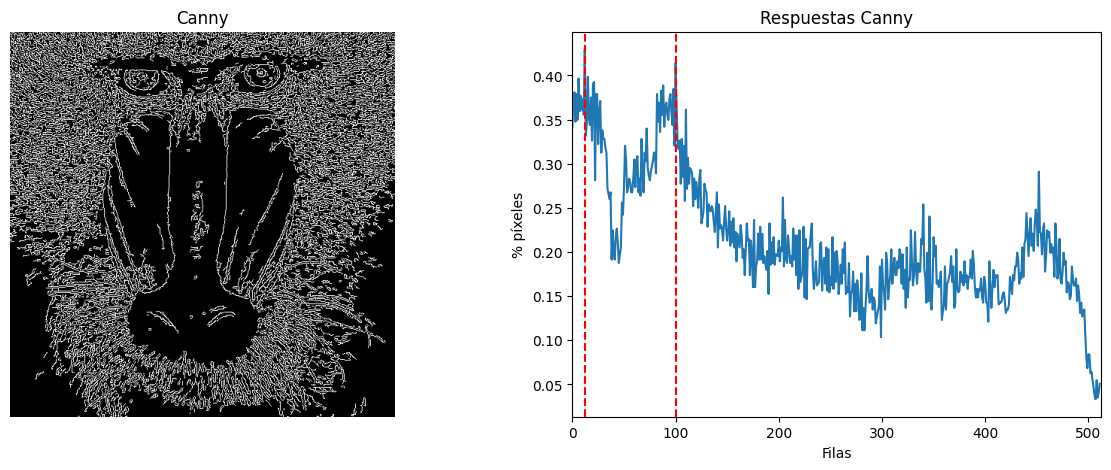

In [2]:
# Cargamos la imagen 
img = cv2.imread('mandril.jpg') 

#Conversión de la imagen a niveles de grises de la imagen original en BGR.
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Obtiene contornos con el operador de Canny.
canny = cv2.Canny(gris, 100, 200)

#Cuenta el número de píxeles blancos (255) por fila.
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

#Normaliza en base al número de filas y al valor máximo del píxel (255).
#El resultado será el número de píxeles blancos por fila.
rows = row_counts[:,0] / (255 * canny.shape[1]) 

# Calcula el valor máximo de píxeles blancos por fila.
maxfil = np.max(rows)

# Determina las filas con píxeles blancos que sean mayor o igual a 0.95.
threshold = 0.95 * maxfil
rows_more_95 = np.where(rows >= threshold)[0]  # Índices de las filas.

# Imprime los resultados en la gráfica.
print(f'Valor máximo de píxeles blancos por fila (maxfil): {maxfil}')
print(f'Filas con al menos el 95% de maxfil (umbral = {threshold}):')
print(rows_more_95)

# Crea una figura más grande con más espacio entre los subplots.
plt.figure(figsize=(15, 5))  

# Muestra la imagen.
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray') 

# Muestra la cuenta de las filas gráficamente.
plt.subplot(1, 2, 2)
plt.xlim([0, len(rows)]) 
plt.title("Respuestas Canny") 
plt.xlabel("Filas")  
plt.ylabel("% píxeles")  
plt.plot(rows)

# Rango en x definido por las columnas.
plt.xlim([0, canny.shape[0]])

# Añade líneas en las filas que cumplen con el criterio de las filas que sean mayor o igual a 95.
for row in rows_more_95:
    plt.axvline(x=row, color='red', linestyle='--')

plt.show()


Sobel. Cuando hay un borde, el valor de intensidad de los píxeles cercanos cambia de forma notable, calcular las derivadas proporciona una evidencia de dicho cambio. El operador de Sobel aproxima el cálculo de la derivada aplicando un kernel de tamaño impar basado en el patrón [1 2 1].

TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.95*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

In [6]:
# Gaussiana para suavizar la imagen original, eliminando altas frecuencias
ggris = cv2.GaussianBlur(gris, (3, 3), 0)

#Calcula en ambas direcciones (horizontal y vertical)
sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)  # x
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)  # y

#Combina ambos resultados
sobel = cv2.add(sobelx, sobely)

# Conversión a byte con openCV
sobel8_v1 = cv2.convertScaleAbs(sobel)

# Conversión a byte con numpy
sobel8_v2 = np.uint8(sobel)

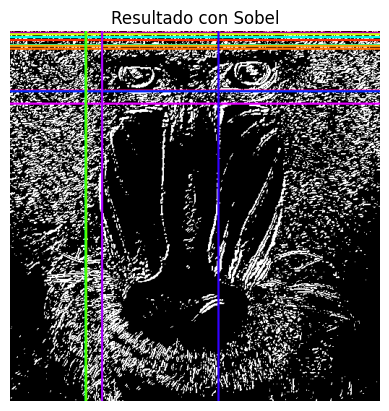

In [10]:
# Define el valor del umbral
valorUmbral = 90

# Obtiene la imagen umbralizada para dicho valor definido
res, imagenUmbralizada = cv2.threshold(sobel8_v1, valorUmbral, 255, cv2.THRESH_BINARY)

# Cuenta de píxeles no nulos por filas y columnas
row_counts = cv2.reduce(imagenUmbralizada, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
col_counts = cv2.reduce(imagenUmbralizada, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

# Normaliza en base al número de filas y al valor máximo del píxel (255)
cols = col_counts[0] / (255 * imagenUmbralizada.shape[1])
rows = []
for element in row_counts:
    rows.append(element[0] / (255 * imagenUmbralizada.shape[0]))

# Encuentra valores máximos y los índices correspondientes
cols_max = np.max(cols)
rows_max = np.max(rows)

# Umbrales al 95% del valor máximo
cols_umbral = cols_max * 0.95
rows_umbral = rows_max * 0.95

# Filas y columnas por encima del umbral
count_rows_greater_than_max_um = [(element, index) for index, element in enumerate(rows) if element >= rows_umbral]
count_cols_greater_than_max_um = [(element, index) for index, element in enumerate(cols) if element >= cols_umbral]

# Convertir la imagen umbralizada a RGB
rgbImagenUmbralizada = cv2.cvtColor(imagenUmbralizada, cv2.COLOR_GRAY2RGB)

# Función para generar colores saturados aleatorios y evitar similitudes
def color_saturado_aleatorio(prev_colors):
    while True:
        hsv_color = np.array([np.random.randint(0, 180), 255, 255], dtype=np.uint8)
        rgb_color = cv2.cvtColor(np.array([[hsv_color]], dtype=np.uint8), cv2.COLOR_HSV2RGB)[0][0]
        rgb_tuple = tuple(int(c) for c in rgb_color)
        
        # Verifica que el nuevo color no sea similar a los anteriores
        if all(np.linalg.norm(np.array(rgb_tuple) - np.array(color)) > 50 for color in prev_colors):
            return rgb_tuple

# Almacena los colores generados para compararlos
prev_colors = []

# Marca filas y columnas con líneas de colores saturados
for row in count_rows_greater_than_max_um:
    color = color_saturado_aleatorio(prev_colors)
    prev_colors.append(color)
    cv2.line(rgbImagenUmbralizada, (0, row[1]), (rgbImagenUmbralizada.shape[1], row[1]), color, 2)

for col in count_cols_greater_than_max_um:
    color = color_saturado_aleatorio(prev_colors)
    prev_colors.append(color)
    cv2.line(rgbImagenUmbralizada, (col[1], 0), (col[1], rgbImagenUmbralizada.shape[0]), color, 2)

# Muestra la imagen con las filas y columnas resaltadas
plt.figure()
plt.axis("off")
plt.title("Resultado con Sobel")
plt.imshow(rgbImagenUmbralizada)

plt.show()


Canny: Detecta bordes más precisos y definidos, con menos píxeles no nulos. Es más selectivo y elimina ruido mediante varios pasos adicionales como la supresión no máxima y la histeresis.

Sobel: Es más sensible a cambios graduales de intensidad, lo que genera más bordes y más píxeles no nulos. Captura detalles más suaves pero con menor precisión.

Sobel es mejor para detalles suaves, mientras que Canny es más adecuado para contornos precisos.

TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, incluya al menos dos usos diferentes de aplicar las funciones de OpenCV trabajadas hasta ahora.

In [8]:
# Inicia la captura de video
vid = cv2.VideoCapture(0)

# Marca de inicio para el temporizador
start_time = time.time()
# Variable para controlar los efectos
mode = 0

# Definir k-means criterios fuera del bucle para posterización
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8  # Número de clusters (niveles de color)

while True:      
    # Captura fotograma a fotograma
    ret, frame = vid.read()

    if ret:
        # Aplica efecto espejo sobre la entrada
        framem = cv2.flip(frame, 1)

        # Alterna entre modos cada 4 segundos
        elapsed_time = time.time() - start_time
        if elapsed_time > 4:
            mode = (mode + 1) % 3  # Cambia entre 0, 1 y 2
            start_time = time.time()  # Resetea el temporizador

        # Aplica diferentes efectos en función de 'mode'
        if mode == 0: 
            cv2.imshow('Efectos en Tiempo Real', framem)

        elif mode == 1:
            # Efecto 2: Posterización (K-means clustering)
            Z = framem.reshape((-1, 3))  
            Z = np.float32(Z)

            _, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

            # Convertimos los colores a 8-bit
            center = np.uint8(center)
            res = center[label.flatten()]
            resultado = res.reshape(framem.shape)
            cv2.imshow('Efectos en Tiempo Real', resultado)

        elif mode == 2: 
            # Efecto 3: Mapa de calor 
            gris = cv2.cvtColor(framem, cv2.COLOR_BGR2GRAY)
            heatmap = cv2.applyColorMap(gris, cv2.COLORMAP_JET)  
            cv2.imshow('Efectos en Tiempo Real', heatmap)

    # Detenemos pulsando ESC
    if cv2.waitKey(20) == 27:
        break

# Libera el objeto de captura
vid.release()
# Destruye todas las ventanas
cv2.destroyAllWindows()


TAREA: Tras ver los vídeos My little piece of privacy, Messa di voce y Virtual air guitar proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.

In [7]:
# Inicia la captura de video desde la cámara web
video = cv2.VideoCapture(0)

# Lee el primer frame de la cámara
ret, Prev_frame = video.read()

# Convierte el primer frame a escala de grises y aplica suavizado
Prev_frame_gray = cv2.cvtColor(Prev_frame, cv2.COLOR_BGR2GRAY)
Prev_frame_gray = cv2.GaussianBlur(Prev_frame_gray, (15, 15), 0)

while True:
    # Captura el siguiente frame de la cámara
    ret, Current_frame = video.read()

    if not ret:
        break  # Si no se puede leer el frame, salimos del bucle

    # Convierte el frame actual a escala de grises y aplica suavizado
    Current_frame_gray = cv2.cvtColor(Current_frame, cv2.COLOR_BGR2GRAY)
    Current_frame_gray = cv2.GaussianBlur(Current_frame_gray, (15, 15), 0)


    sobelx = cv2.Sobel(Current_frame_gray, cv2.CV_64F, 1, 0)  # x
    sobely = cv2.Sobel(Current_frame_gray, cv2.CV_64F, 0, 1)  # y
    #Combina ambos resultados
    sobel = cv2.add(sobelx, sobely)
    sobel_a = cv2.convertScaleAbs(sobel)

    sobel_a = cv2.cvtColor(sobel_a, cv2.COLOR_GRAY2RGB)
    # Calcula la diferencia entre el frame actual y el frame anterior
    frame_diff = cv2.absdiff(Current_frame_gray, Prev_frame_gray)

    # Aplica un umbral para obtener las regiones con movimiento
    _, thresh = cv2.threshold(frame_diff, 10, 255, cv2.THRESH_BINARY)

    # Dilatar la imagen para destacar las áreas de movimiento
    dilate = cv2.dilate(thresh, None, iterations=2)

    # Encuentra los contornos de los objetos en movimiento
    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Dibuja rectángulos sobre las áreas detectadas en movimiento
    if contours:
        all_contours = np.concatenate(contours)
        (x, y, w, h) = cv2.boundingRect(all_contours)
        Current_frame[y:y+h,x:x+w,0] = sobel_a[y:y+h,x:x+w,0]
        Current_frame[y:y+h,x:x+w,1] = sobel_a[y:y+h,x:x+w,1]
        Current_frame[y:y+h,x:x+w,2] = sobel_a[y:y+h,x:x+w,2]
        cv2.rectangle(Current_frame, (x, y), (x + w, y + h), (255, 255, 255), 2)
        
    # Muestra el frame con las áreas de movimiento 
    cv2.imshow("Detección de movimiento - Movimientos suaves", Current_frame)

    # Actualiza el frame anterior
    Prev_frame_gray = Current_frame_gray.copy()

    # Presionar 'ESC' para salir del bucle
    if cv2.waitKey(20) == 27:
        break

# Libera la cámara y cierra la ventana
video.release()
cv2.destroyAllWindows()